In [1]:
import pandas as pd
import numpy as np
import json
import ydata_profiling
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import itertools
from IPython.display import display



%matplotlib inline

tweets_fragments_df = pd.read_pickle('./data/tweets_fragments_all.pkl')

tweets_fragments_df['text'] = tweets_fragments_df['text'].apply(lambda x: np.nan if x==np.nan else str(x).encode('utf-8', 'replace').decode('utf-8'))
tweets_fragments_df['topic'] = tweets_fragments_df['topic'].str.lower().astype('category')
tweets_fragments_df['username'] = tweets_fragments_df['username'].str.lower().astype('category')
tweets_fragments_df['tweet_id'] = tweets_fragments_df['tweet_id'].astype(str)

# Pierwszy ogląd na dane


In [2]:
tweets_fragments_df

,tweet_id,username,date,text_all,text,topic,sentiment
0,1720011855823765544,trzaskowski_,2023-11-02 09:35:00,wiadomość prosto od mera kijowa vitaliy_klychk...,wiadomość prosto od mera kijowa vitaliy_klychk...,ukraina,positive
1,1719636816771285367,pomaska,2023-11-01 08:45:00,pis jest znany z przecinania wstęgi po kilka r...,pis jest znany z przecinania wstęgi po kilka r...,rząd,neutral
2,1719378456910221417,donaldtusk,2023-10-31 15:39:00,meldunek od serca,meldunek od serca,inflacja,Neutral
3,1718925236274336067,pomaska,2023-10-30 09:38:00,drastyczny wzrost ceny hurtowej oleju napędowe...,drastyczny wzrost ceny hurtowej oleju napędowe...,inflacja,negative
4,1718925236274336067,pomaska,2023-10-30 09:38:00,drastyczny wzrost ceny hurtowej oleju napędowe...,15 października pan obajtek z ekipą zapewne od...,sądownictwo,negative
...,...,...,...,...,...,...,...
4085,1672574366033530880,radekfogiel,2023-06-24 11:56:00,prezes pis jarosław kaczyński w bogatyni: my p...,będziemy w unii europejskiej ale będziemy suwe...,unia europejska,positive
4086,1672584172672630784,michaldworczyk,2023-06-24 12:35:00,zjednoczonaprawica bogatynia turów 🇵🇱,zjednoczonaprawica bogatynia turów 🇵🇱,węgiel,neutral
4087,1672585034685898753,sobonartur,2023-06-24 12:38:00,„my jesteś zawsze z ludźmi pracy” morawieckim ...,„my jesteś zawsze z ludźmi pracy”,prawa kobiet,neutral
4088,1672585034685898753,sobonartur,2023-06-24 12:38:00,„my jesteś zawsze z ludźmi pracy” morawieckim ...,morawieckim w bogatyni zjednoczonaprawica,polityka,neutral


In [3]:
tweets_fragments_df.dtypes

tweet_id             object
username           category
date         datetime64[ns]
text_all             object
text                 object
topic              category
sentiment            object
dtype: object

Profilowanie interaktywne:


In [4]:
profile = ydata_profiling.ProfileReport(tweets_fragments_df[['username', 'date', 'topic', 'sentiment']],config_file="profiling_config.yml")

profile.to_file('pierwszy_oglad_na_dane.html')
profile.to_notebook_iframe()

/home/staszek/mgr/wiatrolapy/env/lib/python3.10/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/staszek/mgr/wiatrolapy/env/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the pearson correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"pearson": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'trzaskowski_'')
  warnings.warn(
/home/staszek/mgr/wiatrolapy/env/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the spearman correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"spearman": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error messa

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Obserwacje w etapie 1

1. Duża liczba unikalnych tematów
2. Nieznormalizowane wartości kolumny sentyment


# Normalizacja kolumny sentymentu

Zrobiono normalizację do 4 kategorii (pozytywna, neutralna, negatywna, nieznana) wg arbitralnie wybranego mapowania, nieznanych przypadków jest < 30, więc jest to mały ułamek, który można usunąć.


In [5]:
mappings = {
    1: ['positive', 'pozytywny'],
    -1: ['negative', 'negatywny'],
    'unknown': ['unknown', 'none', 'n/a', '', 'undefined', 'sentiment' ],
    0: ['neutral','neutralny']
    }


def apply_mapping_sentiment(series: str):

    for key in mappings.keys():
        val = np.array(mappings[key])
        if (np.isin(series, val).item() == True):
            return key
        
    raise Exception('Unknown sentiment value:', series)

tweets_fragments_df.sentiment = tweets_fragments_df.sentiment.str.lower().apply(func=apply_mapping_sentiment)


print('Unique values of sentiment:', tweets_fragments_df.sentiment.unique())

Unique values of sentiment: [1 0 -1 'unknown']


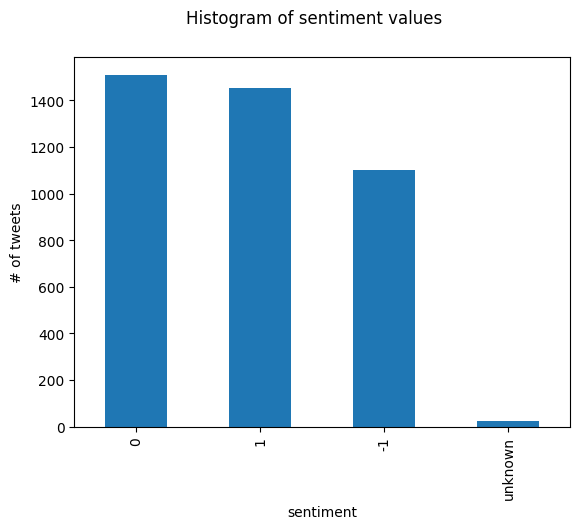

In [6]:
fig, ax = plt.subplots()
tweets_fragments_df['sentiment'].value_counts().plot(kind='bar', ax=ax)
ax.set_ylabel('# of tweets')
fig.suptitle('Histogram of sentiment values')
pass

# Analiza liczby tweetów w czasie

Analiza wykazała szczególnie wysoką liczbę tweetów dziennie w okresie wokół wyborów parlamentarnych 2023. Aktywność użytkowników jako zbiorowości jest mała do września 2022 i zaczyna powoli wzrastać od września 2022.


In [7]:
tweets_fragments_df.drop(index=tweets_fragments_df.loc[tweets_fragments_df.sentiment == 'unknown' , :].index, inplace=True)
tweets_fragments_df['date_rounded'] = tweets_fragments_df.date.dt.round('D') #rounded to full day

Zgrupowanie liczby tweetów w ciągu dnia:


<Axes: xlabel='date_rounded'>

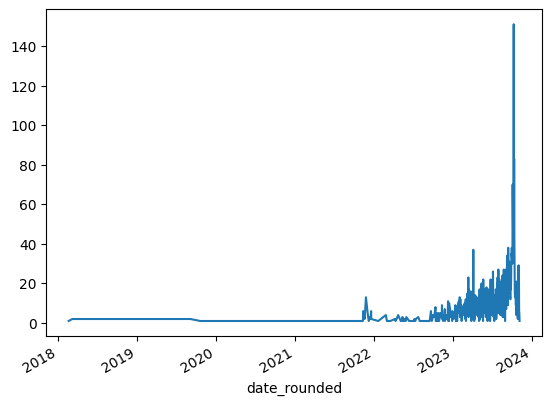

In [8]:
tweets_per_day = tweets_fragments_df['date_rounded'].value_counts().sort_index()

tweets_per_day[tweets_per_day.index > pd.Timestamp(2018, 1, 1)].plot()

In [9]:
px.line(tweets_per_day[tweets_per_day.index > pd.Timestamp(2018, 1, 1)].reset_index(), x='date_rounded', y='count')

# Analiza współwystępowania tematów

Czy niektóre tematy często występują razem w tych samych tweetach? Czy niektóre tematy można zgrupować?

Zaczęto od zrobienia grafu powiązań między tematami:
Węzły to tematy, a krawędzie oznaczają współwystąpienie tematów w tym samym tweecie. Waga krawędzi (`weight`) określa, ile razy doszło do współwystąpienia.


In [10]:
unique_tweets = tweets_fragments_df.tweet_id.unique()
unique_topics = tweets_fragments_df['topic'].unique()
G = nx.Graph()

for topic in unique_topics:
    G.add_node(topic)

print('Graph nodes:', G.nodes)
print('# of nodes:', len(G.nodes))

for tweet_id in unique_tweets:
    matching_fragments = tweets_fragments_df[tweets_fragments_df.tweet_id == tweet_id]
    fragments_topics = matching_fragments.topic.unique()

    if (len(fragments_topics) > 1):
        for combination in itertools.combinations(fragments_topics, r=2):
            if (G.has_edge(combination[0], combination[1])):
                weight = G[combination[0]][combination[1]]['weight']
                nx.set_edge_attributes(G, {(combination[0], combination[1]): {'weight': weight + 1}})
            else:
                G.add_edge(combination[0], combination[1], weight=1)

Graph nodes: ['ukraina', 'rząd', 'inflacja', 'sądownictwo', 'tvp', 'polityka', 'relokacja', 'neutral', 'prawa kobiet', 'podziękowanie', 'marihuana', 'wybory', 'transport publiczny', 'none', 'sport', 'patriotyzm', 'kampania wyborcza', 'nieokreślony', 'prawa wyborcze', 'pojednanie', 'nfz', 'publiczna opieka zdrowotna', 'jedność', 'spotkanie', 'wośp', 'aborcja', 'lgbt', '500plus', 'unknown', 'edukacja seksualna', 'politics', 'przesądy', 'kościół', 'węgiel', 'unspecified', 'policja', 'pfr', 'wdzięczność', 'undefined', 'stany zjednoczone', 'cbos', 'frekwencja wyborcza', 'inne', 'zdrowie', 'równość płac', 'reklama kampanii', 'czas', 'społeczeństwo', 'ekologia', 'covid', 'trójmiasto', 'inwestycje drogowe', 'feminizm', 'telekomunikacja', 'nieznany', 'miejsce', 'kraj', 'telefon', 'bezpieczeństwo', 'świeckie państwo', 'wojsko', 'emerytura', 'imigranci', 'polityka zagraniczna', 'przemoc', 'solidarność', 'personal', 'rekomendacja', 'nierówność majątkowa', 'wspólnota', 'polityczne', 'prawa zwierząt

In [11]:
weights_values = np.array(list(nx.get_edge_attributes(G, 'weight').values()))

px.histogram(weights_values, title='Histogram of edges with specific weight')

Wyrysowanie grafu bez węzłów zerowego stopnia:


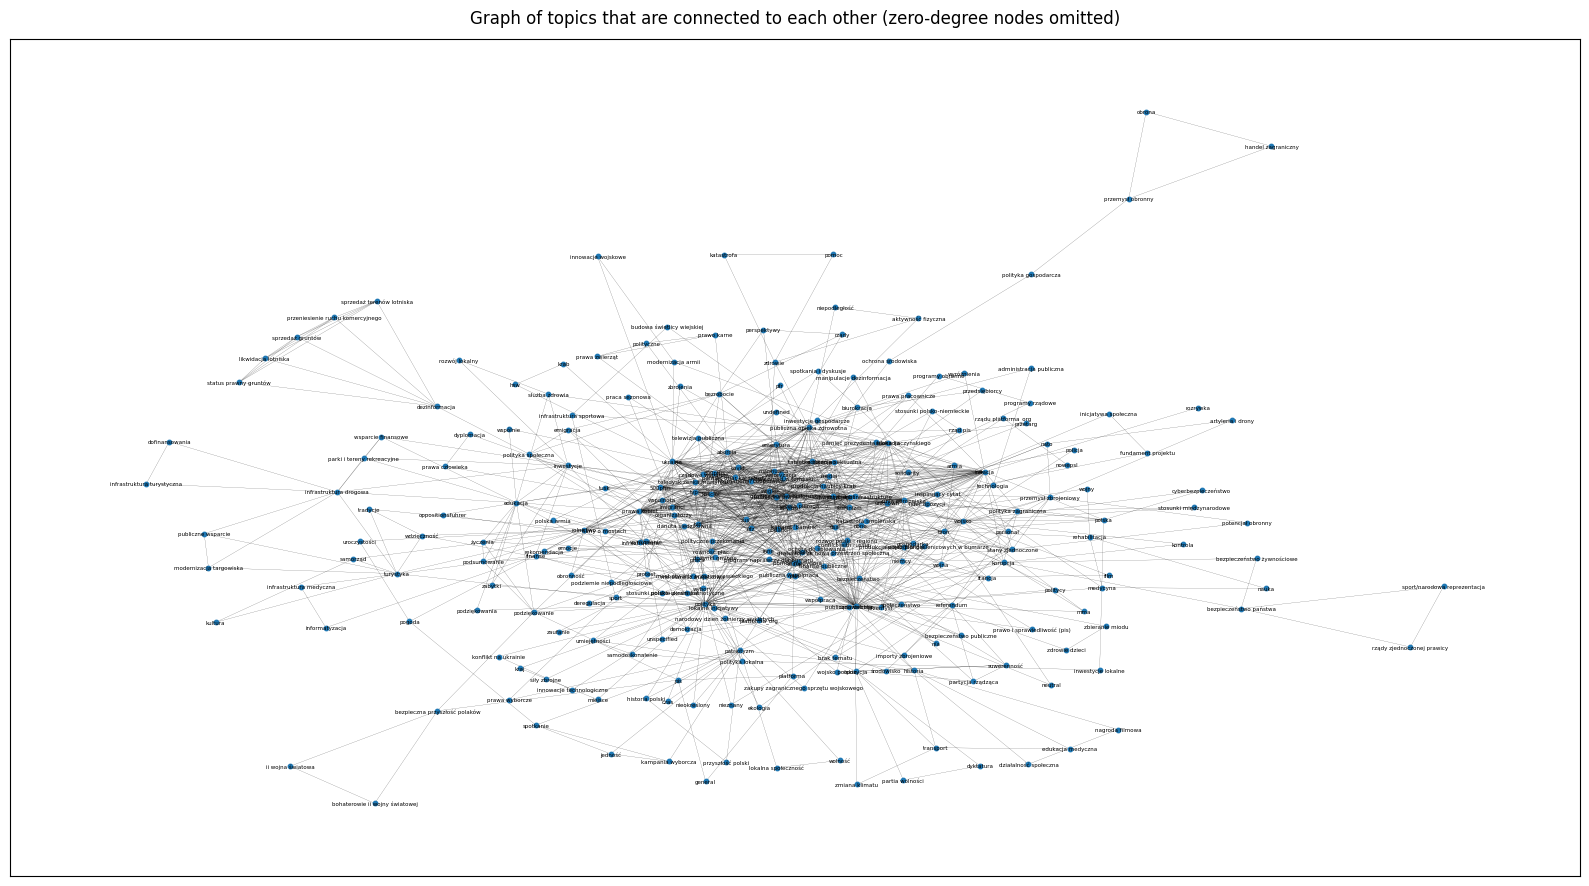

In [12]:
nodes_with_degree_higher_than_n = {k : v for (k, v) in dict(G.degree).items() if v > 1}
subgraph = G.subgraph(nodes_with_degree_higher_than_n.keys())

pos = nx.kamada_kawai_layout(subgraph)

fig, ax = plt.subplots()

nx.draw_networkx(subgraph, pos=pos, ax=ax, node_size=10, nodelist=nodes_with_degree_higher_than_n.keys(), font_size=4, width=0.1)
fig.suptitle('Graph of topics that are connected to each other (zero-degree nodes omitted)')
fig.set_size_inches(16, 9)
fig.tight_layout()
pass

Utworzenie dataframe z wagą każdego współwystąpienie i wyciągnięcie top 30 najczęstszych:


In [13]:
topics_connections_df = pd.DataFrame(columns=['topic1', 'topic2', 'weight'])

for edge, weight in (nx.get_edge_attributes(G, 'weight')).items():
    k1, k2 = edge
    topics_connections_df.loc[len(topics_connections_df)] = (k1, k2, weight)

topics_connections_df.sort_values(by='weight').tail(30)

,topic1,topic2,weight
105,inflacja,polityka,8
274,polityka,gospodarka,8
361,prawa kobiet,500plus,8
100,inflacja,rosja,8
3,ukraina,unia europejska,9
902,unia europejska,usa,9
103,inflacja,500plus,9
144,sądownictwo,tvp,10
842,rosja,unia europejska,10
241,polityka,prawa kobiet,10


Analiza wykazała, że niektóre tematy współwystępują w tweetach, ale z punktu widzenia dziedzinowego nie zawsze można je sensownie złączyć na bazie tego powiązania.

Nie ma np. sensu łączyć 'rząd' i 'sądownictwo', gdyż zbyt naruszamy różnorodność tematów (rząd i sądownictwo wydają się być osobnymi tematami). Z kolei równość płac i prawa kobiet są podobne i można je złączyć w jeden temat.

Konieczne będzie złączenie tematów w sposób ręczny w oparciu o ręczną ocenę powiązania.


# Łączenie tematów w grupy i analiza wspominania tematów


In [14]:
px.bar(tweets_fragments_df[['topic']].value_counts().reset_index().head(100), x='topic', y='count', title='Number of times a topic was mentioned (cutoff to top 100)')

In [15]:
tweets_fragments_df[['topic']].value_counts().loc[lambda count: count > 1]

topic                     
sądownictwo                   353
polityka                      296
publiczna opieka zdrowotna    196
inflacja                      196
prawa kobiet                  167
                             ... 
miejsca turystyczne             2
energetyka                      2
technologia                     2
służby medyczne                 2
mieszkanieplus                  2
Name: count, Length: 230, dtype: int64

In [16]:
tweets_fragments_df[['topic']].value_counts().reset_index().head(100).topic.to_csv('topics_100.csv', header=False, index=False)

In [17]:
tweets_fragments_df[['topic']].value_counts().reset_index().iloc[100:200].topic.to_csv('topics_100-200.csv', header=False, index=False)

Przeprowadzono ręczne przypisanie tematów do większych grup (`supertopics`). Do tej operacji wzięto tylko tematy poruszone co najmniej 2 razy (240 tematów). Otrzymano z tego przypisania 39 tematów. Wyniki zawarto w doku: https://docs.google.com/document/d/1m877VKY6--NY3Wz9BwgbefLPHH5_3m-mrWNJeCBzHyE/edit


In [18]:
import re
with open('Tematy do AMC.txt', mode='r', encoding='utf-8-sig') as file:
    result_dict = {}

    replace_num = re.compile(r"\s*[0-9]+.\s")
    for line in file:
        if (line.startswith(' ')):
            result_dict[current_supertopic].append(re.sub(replace_num, '', line).strip())
        else:
            current_supertopic = re.sub(replace_num, '', line).strip()
            # print(current_supertopic)
            result_dict[current_supertopic] = []
            pass

def get_supertopic(x: str):
    for key in result_dict.keys():
        value = result_dict[key]
        if x in value:
            return key
    return 'Inne'
tweets_fragments_df['supertopic'] = tweets_fragments_df['topic'].apply(get_supertopic)

In [19]:
px.bar(tweets_fragments_df['supertopic'].value_counts().reset_index(), x='supertopic', y='count', title='Number of times a supertopic was mentioned')

Utworzenie macierzy użytkownik-supertemat (z liczbą poruszeń tematu jako elementami)


In [20]:
mentions_matrix = tweets_fragments_df[['username', 'supertopic']].groupby(by=['username', 'supertopic']).size().reset_index().rename(columns={0: 'mentions'}).pivot(index='username', columns='supertopic', values='mentions').T
mentions_matrix

username,a_milczanowska,a_niedzielski,arekmularczyk,barbaraanowacka,bbudka,beatamk,bwroblewski,c_grabarczyk,czarnecki_pis,donaldtusk,...,sjkaleta,sobonartur,stanczykmaciej,styszka,szefernaker,szymon_holownia,trzaskowski_,waldemar_buda,waldydzikowski,wassermann_ma
supertopic,,,,,,,,,,,,,,,,,,,,,
Administracja państwowa,0,0,0,0,0,0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Covid,0,110,0,0,0,0,0,0,2,3,...,0,0,0,0,0,0,0,0,0,0
Demokracja,0,0,0,0,0,0,1,0,0,3,...,0,0,0,0,0,2,0,0,0,0
"Demokracja, wybory i referendum",0,0,0,4,0,0,0,0,3,0,...,0,0,0,0,0,0,9,0,0,0
Edukacja,0,14,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
Edukacja seksualna,0,10,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,3,0,0,0
"Emerytura, seniorzy i ZUS",0,0,0,0,0,0,3,0,10,0,...,0,0,0,0,0,0,0,0,0,0
Energetyka i paliwo,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
Imigranci,0,3,0,0,0,0,1,0,18,14,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Number of mentions of the topic per user')

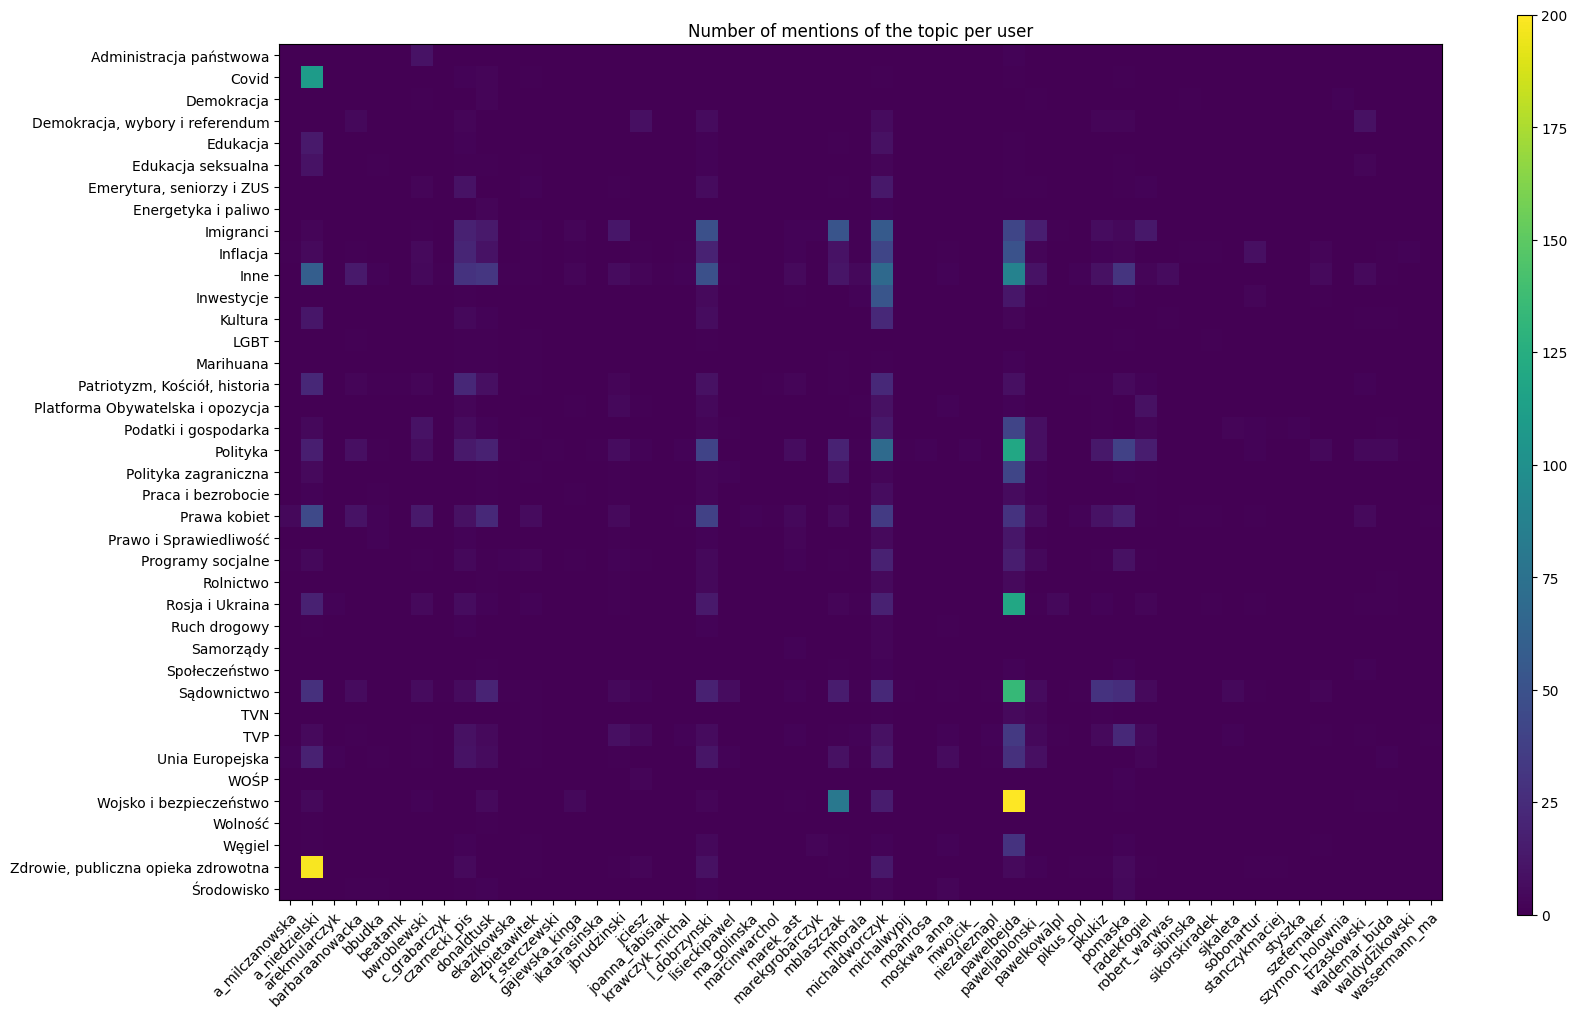

In [21]:
fig, ax = plt.subplots()

image = ax.imshow(mentions_matrix)
fig.set_size_inches(15, 15)
ax.set_yticks(np.arange(len(mentions_matrix.index)), labels=mentions_matrix.index)
ax.set_xticks(np.arange(len(mentions_matrix.columns)), labels=mentions_matrix.columns, rotation=45, rotation_mode='anchor', ha='right')

cax = fig.add_axes([0.95, 0.2, 0.01, 0.6])
fig.colorbar(image, cax=cax)
ax.set_title('Number of mentions of the topic per user')

Zaobserwowano, że zdarzają się przypadki, że użytkownik tego samego dnia wspomina dany temat więcej niż raz (prawdopodobnie w tym samym tweecie), ale niekoniecznie z tym samym sentymentem. Podjęto próbę wykrycia takich przypadków.


In [22]:
def test():
    for user in mentions_matrix.columns:
        filtered_df = tweets_fragments_df.loc[(tweets_fragments_df.username == user ), ['date_rounded', 'supertopic', 'text_all', 'sentiment']]
        is_empty = filtered_df.shape[0] == 0

        if not is_empty:
            return filtered_df.drop_duplicates()
            
df = test()

display(df) #sample of the mentioned situation

display(df.groupby(by=['date_rounded', 'supertopic', 'text_all']).mean().reset_index()) # sample after fixing

,date_rounded,supertopic,text_all,sentiment
1094,2023-08-15,Programy socjalne,🇵🇱 polska będzie się rozwijała i będzie bogats...,1
1099,2023-07-31,Prawa kobiet,🇵🇱 chcemy polski bezpiecznej i takiej w której...,1
1100,2023-07-31,Unia Europejska,🇵🇱 chcemy polski bezpiecznej i takiej w której...,0
1101,2023-07-31,Unia Europejska,🇵🇱 chcemy polski bezpiecznej i takiej w której...,1
3239,2023-10-05,Inflacja,bezpiecznapolska,0
3309,2023-05-31,Prawa kobiet,📢 czy pod takim hasłem chcesz iść w marsz4czer...,0


,date_rounded,supertopic,text_all,sentiment
0,2023-05-31,Prawa kobiet,📢 czy pod takim hasłem chcesz iść w marsz4czer...,0.0
1,2023-07-31,Prawa kobiet,🇵🇱 chcemy polski bezpiecznej i takiej w której...,1.0
2,2023-07-31,Unia Europejska,🇵🇱 chcemy polski bezpiecznej i takiej w której...,0.5
3,2023-08-15,Programy socjalne,🇵🇱 polska będzie się rozwijała i będzie bogats...,1.0
4,2023-10-05,Inflacja,bezpiecznapolska,0.0


In [23]:
def test():
    for user in mentions_matrix.columns:
        filtered_df = tweets_fragments_df.loc[(tweets_fragments_df.username == user ), ['date_rounded', 'supertopic', 'text_all', 'sentiment']]
        is_empty = filtered_df.shape[0] == 0

        if not is_empty:
            df = filtered_df.drop_duplicates().groupby(by=['date_rounded', 'supertopic', 'text_all']).mean().reset_index()
            fig = px.line(df.groupby(by=['date_rounded', 'supertopic', 'text_all']).mean().reset_index(), x='date_rounded', y='sentiment', color='supertopic', markers=True, hover_data=['text_all'], title=f'Sentiment changes for user {user}')
            fig.update_layout(
                hoverlabel=dict(
                    bgcolor="white",
                    font_size=16,
                    namelength=100
                )
            )
            fig.show()
test()